# Validation: test2

The test is validation on gnomAD data (selected SNPs with population frequency 5% or more) and ClinVar data (2022-05-07 18:17) https://ftp.ncbi.nlm.nih.gov/pub/clinvar/vcf_GRCh38/

## 1. Data preparation

Removing headers:

```bash
cat gnomad_hg38_af5pct.vcf | grep -v ^## > gnomad_hg38_af5pct_no_header.vcf
cat clinvar.vcf | grep -v ^## > clinvar_no_header.vcf
awk 'NR>1' clinvar_no_header.vcf > clinvar_for_merging.vcf
```

Merging files:

```bash
cat gnomad_hg38_af5pct_no_header.vcf clinvar_for_merging.vcf > merged_data.vcf
```

Sorting data:

```bash
cat merged_data.vcf | awk '$1 ~ /^#/ {print $0;next} {print $0 | "LC_ALL=C sort -k1,1 -k2,2n"}' > sorted_data.vcf
```

Splitting data into 3 parts:

In [1]:
import pandas as pd
import allel

In [3]:
sorted_data = allel.vcf_to_dataframe('./sorted_data.vcf')

In [4]:
sorted_data.shape

(12032635, 9)

## 2. Running VEP

```bash
path_to_vep/vep --cache -canonical -i ./sorted_data.vcf -o ./test2_vep_coding.vcf --coding_only
```

There were some problems with annotationg such a huge file and VEP finished after annotationg 5338604 SNPs <br>
I decided to analyse 5000000 of SNPs

```bash
head -n 5000043 test2_vep_coding.vcf > test2.vcf
```

## 3. Running MNVFinder

```bash
python ../../code/mnvfinder.py -i test2.vcf -o .
```
The output:
```bash
Reading data...
Searching for polymorphisms in the same codon...
Would like to save file with MNVs annotated as SNPs? y/n y
Would like to save file with SNP annotation without misannotated MNVs? y/n y
Annotating MNVs...
Succesfully finished
Found 4414 MNVs:
missense_variant 4120
stop_lost 209
stop_gained 44
synonymous_variant 41
The output file(s) can be found in  .
```

## 4. Analysing results

### 4.1 Calculating theoretical effect of SNPs and MNVs

In [1]:
code = {'TTT' : 'F', 'TTC' : 'F', 'TTA' : 'L', 'TTG' : 'L', 
        'TCT' : 'S', 'TCC' : 'S', 'TCA' : 'S', 'TCG' : 'S', 
        'TAT' : 'Y', 'TAC' : 'Y', 'TAA' : '*', 'TAG' : '*', 
        'TGT' : 'C', 'TGC' : 'C', 'TGA' : '*', 'TGG' : 'W', 
        'CTT' : 'L', 'CTC' : 'L', 'CTA' : 'L', 'CTG' : 'L', 
        'CCT' : 'P', 'CCC' : 'P', 'CCA' : 'P', 'CCG' : 'P', 
        'CAT' : 'H', 'CAC' : 'H', 'CAA' : 'Q', 'CAG' : 'Q', 
        'CGT' : 'R', 'CGC' : 'R', 'CGA' : 'R', 'CGG' : 'R', 
        'ATT' : 'I', 'ATC' : 'I', 'ATA' : 'I', 'ATG' : 'M', 
        'ACT' : 'T', 'ACC' : 'T', 'ACA' : 'T', 'ACG' : 'T', 
        'AAT' : 'N', 'AAC' : 'N', 'AAA' : 'K', 'AAG' : 'K', 
        'AGT' : 'S', 'AGC' : 'S', 'AGA' : 'R', 'AGG' : 'R', 
        'GTT' : 'V', 'GTC' : 'V', 'GTA' : 'V', 'GTG' : 'V', 
        'GCT' : 'A', 'GCC' : 'A', 'GCA' : 'A', 'GCG' : 'A', 
        'GAT' : 'D', 'GAC' : 'D', 'GAA' : 'E', 'GAG' : 'E', 
        'GGT' : 'G', 'GGC' : 'G', 'GGA' : 'G', 'GGG' : 'G'}

In [2]:
letters = ['A', 'C', 'T', 'G']

In [3]:
consequences = {'synonymous_variant':0, 'missense_variant':0, 'stop_gained':0, 'stop_lost':0}
for codon in code:
    aa = code[codon]
    for position in range(3):
        for letter in letters:
            new_codon = codon
            new_codon = list(new_codon)
            new_codon[position] = letter
            if new_codon != codon:
                new_aa = code[''.join(new_codon)]
                if new_aa == aa:
                    consequences['synonymous_variant'] += 1
                elif new_aa == '*':
                    consequences['stop_gained'] += 1
                elif aa == '*':
                    consequences['stop_lost'] += 1
                else:
                    consequences['missense_variant'] += 1

In [4]:
consequences

{'synonymous_variant': 330,
 'missense_variant': 392,
 'stop_gained': 23,
 'stop_lost': 23}

In [5]:
impact = {}
impact['LOW'] = consequences['synonymous_variant']
impact['MODERATE'] = consequences['missense_variant']
impact['HIGH'] = consequences['stop_gained'] + consequences['stop_lost']

In [6]:
impact

{'LOW': 330, 'MODERATE': 392, 'HIGH': 46}

In [7]:
MNconsequences = {'synonymous_variant':0, 'missense_variant':0, 'stop_gained':0, 'stop_lost':0}
pairs = {}
codons = []

for codon in code:
    pairs[codon] = []
    codons.append(codon)

for codon in codons:
    for other_codon in codons:
        if codon[0] == other_codon[0] and codon[1] != other_codon[1] and codon[2] != other_codon[2]:
            pairs[codon].append(other_codon)
        elif codon[0] != other_codon[0] and codon[1] == other_codon[1] and codon[2] != other_codon[2]:
            pairs[codon].append(other_codon)
        elif codon[0] != other_codon[0] and codon[1] != other_codon[1] and codon[2] == other_codon[2]:
            pairs[codon].append(other_codon)

for codon in pairs:
    aa = code[codon]
    for other_codon in pairs[codon]:
        new_aa = code[other_codon]
        if new_aa == aa:
            MNconsequences['synonymous_variant'] += 1
        elif new_aa == '*':
            MNconsequences['stop_gained'] += 1
        elif aa == '*':
            MNconsequences['stop_lost'] += 1
        else:
            MNconsequences['missense_variant'] += 1

In [8]:
MNconsequences

{'synonymous_variant': 30,
 'missense_variant': 1540,
 'stop_gained': 79,
 'stop_lost': 79}

In [11]:
MNimpact = {}
MNimpact['LOW'] = MNconsequences['synonymous_variant']
MNimpact['MODERATE'] = MNconsequences['missense_variant']
MNimpact['HIGH'] = MNconsequences['stop_gained'] + MNconsequences['stop_lost']

In [12]:
MNimpact

{'LOW': 30, 'MODERATE': 1540, 'HIGH': 158}

### 4.2 Calculationg obtained effect of SNPs and MNVs

In [13]:
import pandas as pd

In [14]:
snp_data = pd.read_csv('snps.tab', sep='\t', engine='python')

In [15]:
snp_err_data = pd.read_csv('snps_err.tab', sep='\t', engine='python')

In [24]:
snp_err_data = snp_err_data.sort_values('Gene')
genes = list(snp_err_data['Gene'].unique())
out = pd.DataFrame(columns=snp_err_data.columns)
for i in genes:
    gene_table = snp_err_data.loc[snp_err_data['Gene'] == i]
    gene_table = gene_table.drop_duplicates('Protein_position')
    out = pd.concat([out, gene_table])
snp_err_data = out

In [16]:
mnv_concequences = {'synonymous_variant':41, 'missense_variant':4120, 'stop_gained':44, 'stop_lost':209}
mnv_impact = {}
mnv_impact['LOW'] = mnv_concequences['synonymous_variant']
mnv_impact['MODERATE'] = mnv_concequences['missense_variant']
mnv_impact['HIGH'] = mnv_concequences['stop_gained'] + mnv_concequences['stop_lost']
mnv_impact

{'LOW': 41, 'MODERATE': 4120, 'HIGH': 253}

In [17]:
snp_consequences = {'synonymous_variant':0, 'missense_variant':0, 'stop_gained':0, 'stop_lost':0, 'start_lost':0}
for i in snp_data['Consequence']:
    if 'synonymous_variant' in i:
        snp_consequences['synonymous_variant'] += 1
    elif 'missense_variant' in i:
        snp_consequences['missense_variant'] += 1
    elif 'stop_gained' in i:
        snp_consequences['stop_gained'] += 1
    elif 'stop_lost'in i:
        snp_consequences['stop_lost'] += 1
    elif 'start_lost' in i:
        snp_consequences['start_lost'] += 1
snp_consequences

{'synonymous_variant': 144772,
 'missense_variant': 220000,
 'stop_gained': 16578,
 'stop_lost': 935,
 'start_lost': 247}

In [20]:
snp_impact = {}
snp_impact['LOW'] = snp_consequences['synonymous_variant']
snp_impact['MODERATE'] = snp_consequences['missense_variant']
snp_impact['HIGH'] = snp_consequences['stop_gained'] + snp_consequences['stop_lost']
snp_impact

{'LOW': 144772, 'MODERATE': 220000, 'HIGH': 17513}

In [40]:
snp_err_consequences = {'synonymous_variant':0, 'missense_variant':0, 'stop_gained':0, 'stop_lost':0, 'start_lost':0}
for i in snp_err_data['Consequence']:
    if 'synonymous_variant' in i:
        snp_err_consequences['synonymous_variant'] += 1
    elif 'missense_variant' in i:
        snp_err_consequences['missense_variant'] += 1
    elif 'stop_gained' in i:
        snp_err_consequences['stop_gained'] += 1
    elif 'stop_lost'in i:
        snp_err_consequences['stop_lost'] += 1
    elif 'start_lost' in i:
        snp_err_consequences['start_lost'] += 1
snp_err_consequences

{'synonymous_variant': 230700,
 'missense_variant': 386707,
 'stop_gained': 28976,
 'stop_lost': 631,
 'start_lost': 1007}

In [41]:
snp_err_impact = {}
snp_err_impact['LOW'] = snp_err_consequences['synonymous_variant']
snp_err_impact['MODERATE'] = snp_err_consequences['missense_variant']
snp_err_impact['HIGH'] = snp_err_consequences['stop_gained'] + snp_err_consequences['stop_lost']
snp_err_impact

{'LOW': 230700, 'MODERATE': 386707, 'HIGH': 29607}

### 4.3 Plotting

In [25]:
import matplotlib.pyplot as plt

#### Theoretical impact

Text(0.5, 1.0, 'MNVs impact')

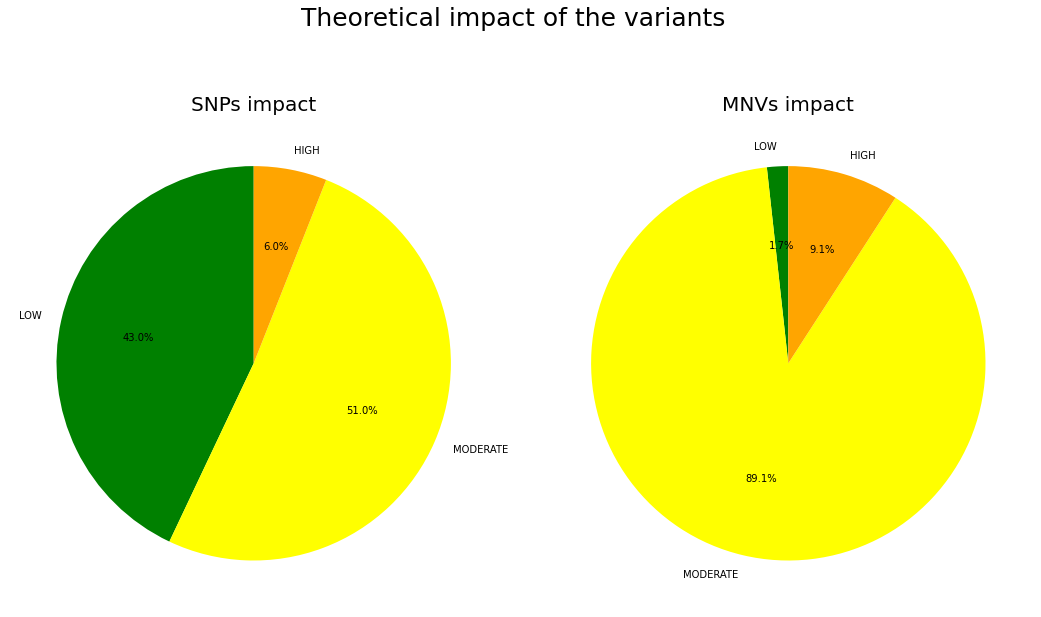

In [38]:
labels = ['LOW', 'MODERATE', 'HIGH']
snp_sizes = [330, 392, 46]
mnv_sizes = [30, 1540, 158]
colors = ['green', 'yellow', 'orange']

fig, axes = plt.subplots(ncols = 2, figsize=(15,10))
plt.suptitle('Theoretical impact of the variants', size = 25)
fig.tight_layout()

axes[0].pie(snp_sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
axes[0].set_title('SNPs impact', size = 20)

axes[1].pie(mnv_sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
axes[1].set_title('MNVs impact', size = 20)

#### The obtained impact

Text(0.5, 1.0, 'MNVs impact')

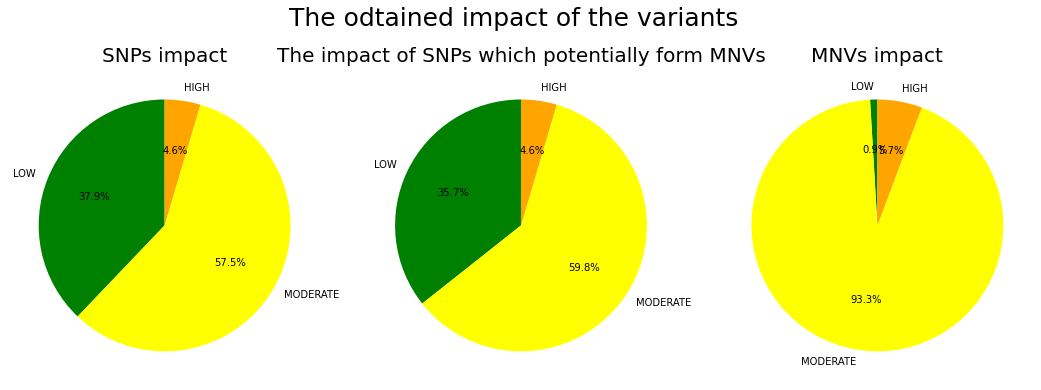

In [44]:
{'LOW': 230700, 'MODERATE': 386707, 'HIGH': 29607}
labels = ['LOW', 'MODERATE', 'HIGH']
snp_sizes = [144772, 220000, 17513]
snp_err_sizes = [230700, 386707, 29607]
mnv_sizes = [41, 4120, 253]
colors = ['green', 'yellow', 'orange']

fig, axes = plt.subplots(ncols = 3, figsize=(15,6))
plt.suptitle('The odtained impact of the variants', size = 25)
fig.tight_layout()

axes[0].pie(snp_sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
axes[0].set_title('SNPs impact', size = 20)

axes[1].pie(snp_err_sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
axes[1].set_title('The impact of SNPs which potentially form MNVs', size = 20)

axes[2].pie(mnv_sizes, labels=labels, colors=colors, startangle=90, autopct='%1.1f%%')
axes[2].set_title('MNVs impact', size = 20)